# Big Data, Big Trust: Assessing Reliability in the Online World

## An introduction to the project

In a world where data is crucial, and online reviews strongly affect our choices, there's a hidden challenge at play. Our goal is to uncover the hidden truths about web reliability. We're not typical heroes; we dive into the digital world, revealing those who manipulate information. Welcome to a journey where the stakes are high, the secrets are deep, and the discoveries are thrilling. Get ready, because this isn't your usual research project.

Our aim is to help customers understand product problems better and assist companies in making better products. We'll use spaCy to find out what's wrong with different tablets by analyzing customer reviews from a popular online store.

Let's begin this exciting adventure!

## Importing the packages

In [2]:
import numpy as np
import pandas as pd
import spacy
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import random
from spacy.matcher import Matcher
from sklearn.model_selection import train_test_split
from spacy.tokens import DocBin
from tqdm import tqdm
from spacy.util import filter_spans
import seaborn as sns
import nltk


## Loading the Data

In [3]:
#The training Dataset
df_train=pd.read_csv("training_data.csv")
df_train.head()

,review_id,tablet_id,comment,stars,Failure class
0,Big_dataset_1,Big_dataset,Customer support wants to take the computer ba...,1,TF
1,Big_dataset_2,Big_dataset,"Overall, a good experience. Fast and responsiv...",3,TF
2,Big_dataset_3,Big_dataset,I got this Chromebook recent for a trip I need...,5,NaN
3,Big_dataset_4,Big_dataset,Just what I wanted\n,5,NaN
4,Big_dataset_5,Big_dataset,"Good battery life, thin and lightweight, handy...",4,TF


In [4]:
#The test Dataset
df_test=pd.read_csv("test_data.csv")
df_test.head()

,review_id,tablet_id,comment,stars,Failure class
0,acer_chromebook_1,acer_chromebook,_x000D_\n I bought this for use mainly for wo...,3,IF
1,acer_chromebook_2,acer_chromebook,_x000D_\n Though ChromeOS can take some getti...,5,NaN
2,acer_chromebook_3,acer_chromebook,_x000D_\n I was so over the moon with this pr...,3,IF
3,acer_chromebook_4,acer_chromebook,_x000D_\n According to my account I purchased...,5,NaN
4,acer_chromebook_5,acer_chromebook,_x000D_\n My son's 5th grade class requires a...,5,TF


## The wordcloud

Let's see the most frequent words in the comments we're working with,to have more knowledge about the dataset.

In [5]:
comment_words=' '
stopwords=set(STOPWORDS) #This creates a set of stopwords,words like 'the','and','in',etc.
for review in df_train['comment']:

    #type each value to string
    review=str(review).lower()

    #split value
    tokens=review.split()
    comment_words=comment_words+' '.join(tokens)


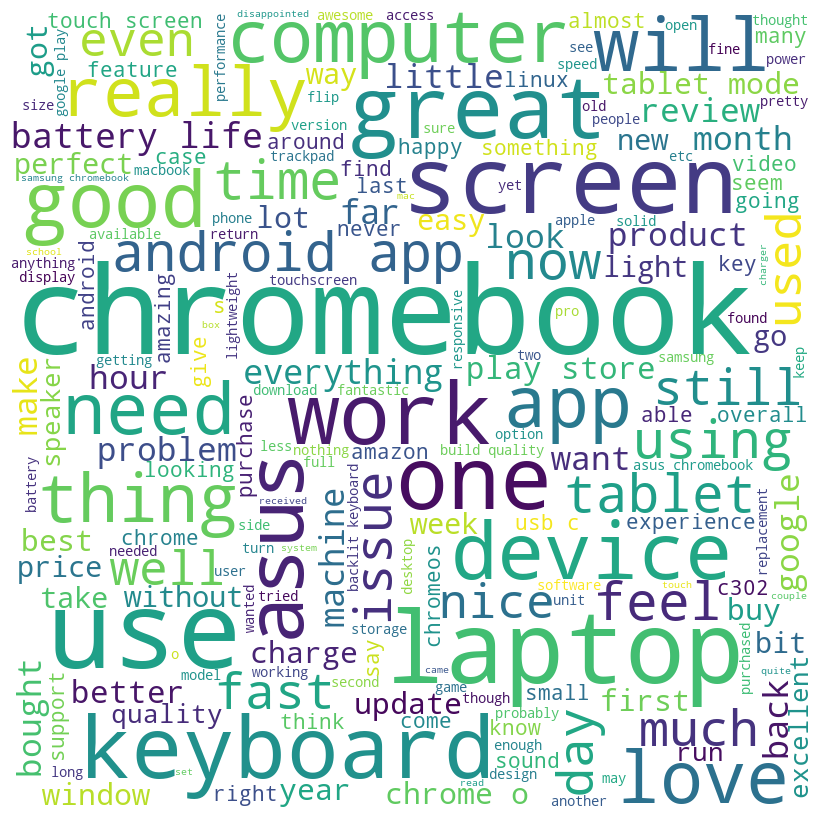

In [6]:
wordcloud=WordCloud(width=800,height=800,background_color='white',
                    stopwords=stopwords,
                    min_font_size=10).generate(comment_words)

#plotting the figure
plt.figure(figsize=(8,8),facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig('wordcloud')
plt.show()

## Number of words per review

Now,let's see how many words per review we find in this dataset,to get more accurate results we will preprocess the reviews using the function below.

In [7]:
def process_review(review):
    processed_token = []
    for token in review.split():
        token = ''.join(e.lower() for e in token if e.isalnum())
        processed_token.append(token)
    return ' '.join(processed_token)

In [8]:
initial_comments=df_train['comment'].to_list()

In [9]:
comments=[]
for review in df_train['comment']:
    comments.append(process_review(review))

C:\Users\oumai\AppData\Local\Temp\ipykernel_15392\3680787047.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_sentences_size)


Text(0.5, 1.0, 'Word Frequency Distribution in Reviews')

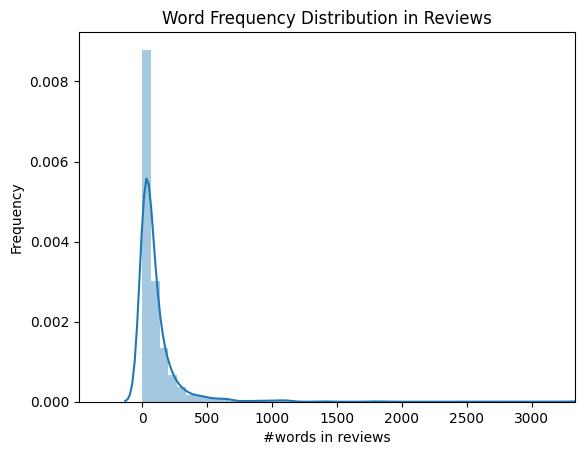

In [10]:
import seaborn as sns

train_sentences_size = list(map(lambda x: len(x.split()), initial_comments))

sns.distplot(train_sentences_size)
# Set limits for the x-axis
plt.xlim( -490,max(train_sentences_size)) 
plt.xlabel("#words in reviews")
plt.ylabel("Frequency")
plt.title("Word Frequency Distribution in Reviews")

## Information extraction

Now,we'll dig deep into the real stuff 


### Separating the Data

In [11]:
# We're interested only to the failure-related comments.

# Create a DataFrame for non-failure reviews
NF_df_train = df_train[df_train["Failure class"].isnull()]

# Create a DataFrame for failure reviews
F_df_train = df_train[(df_train["Failure class"] == "TF")|(df_train['Failure class']=="IF")]


In [12]:
F_df_train.head()

,review_id,tablet_id,comment,stars,Failure class
0,Big_dataset_1,Big_dataset,Customer support wants to take the computer ba...,1,TF
1,Big_dataset_2,Big_dataset,"Overall, a good experience. Fast and responsiv...",3,TF
4,Big_dataset_5,Big_dataset,"Good battery life, thin and lightweight, handy...",4,TF
5,Big_dataset_6,Big_dataset,I would give this zero stars if that were an o...,1,IF
6,Big_dataset_7,Big_dataset,"Great little laptop. Fantastic battery life, q...",5,TF


In [13]:
F_df_train.shape

(356, 5)

So we get 356 comments that are classified as 'failure'.We save then this dataset.

In [14]:
F_df_train.to_csv('F_df_train')

## Extracting entities using spaCy

In [15]:
# First let's check some NERs in first 10 reviews and remove date, time, ordinal and cardinal.
nlp = spacy.load('en_core_web_sm')
count = 0
for review in F_df_train['comment']:
    if count < 11:
        doc = nlp(review)
        ents = [(e.text, e.label_) for e in doc.ents if e.label_ not in ('DATE', 'TIME', 'ORDINAL', 'CARDINAL')]
        print(ents)
    count += 1

[]
[]
[('MacBook', 'PRODUCT')]
[('ASUS', 'ORG'), ('$$$', 'MONEY')]
[('Android', 'PERSON'), ('Keyboard', 'ORG'), ('Windows', 'NORP')]
[('Audio', 'PERSON')]
[('Screen', 'ORG'), ('google', 'ORG')]
[]
[]
[('Amazon', 'ORG')]
[]


The NER model is able to categorize some famous organisations (like Asus and google),but that's not what we want.
For our project,our model should define component and failure modes of tablets,to do so,we should customize the model to our needs.

## Training Data for NER using spaCy

### Preparing the training Data

For this part,i will label manually ~300 comments from the ones that present a failure

In [17]:
failure_train_300=pd.DataFrame(F_df_train['comment'].iloc[:300]) #Extracting the first 300 comments only 
failure_train_300.head()

,comment
0,Customer support wants to take the computer ba...
1,"Overall, a good experience. Fast and responsiv..."
4,"Good battery life, thin and lightweight, handy..."
5,I would give this zero stars if that were an o...
6,"Great little laptop. Fantastic battery life, q..."


Using this Dataset , i created an excel file containing for each comment,the component and the failure mode.

In [18]:


# Load the Excel file into a pandas DataFrame
excel_file = "C:/Users/oumai/Documents/Studies/3A/FMR/Etude de cas/My work/Failure_entities.xlsx"
df_NER = pd.read_excel(excel_file).dropna()
df_NER=df_NER.drop('Id',axis=1)
#Splitting the data
train_df, test_df = train_test_split(df_NER, test_size=0.2, random_state=42)
# Extract the relevant columns
comments_train = train_df['comment'].tolist()
entities_train = train_df[['component', 'failure mode']].values.tolist()

comments_test = test_df['comment'].tolist()
entities_test = test_df[['component', 'failure mode']].values.tolist()


In [19]:
train_df.head()

,comment,component,failure mode
132,I bought this in hopes of replacing my older T...,keyboard,keyboard are terrific
202,"GARBAGE. First one stopped charging, so I had ...",charging,stopped charging
196,"I bought a Samsung Chromebook Pro in August, 2...",font,the font is so small I can barely read it
75,Super nice keyboard. I really enjoy typing on ...,speakers,the speakers on it aren't very loud at all
176,It\'s a really nice laptop and a decent tablet...,edges,cracks along the front curved edges


Let's start by writing the training Data in the appropriate format.

In [20]:
#First let's start with components
data_component_train= []
nlp = spacy.load("en_core_web_sm")
for comment_train, entity_pair_train in zip(comments_train, entities_train):
    component_train, failure_mode_train = entity_pair_train
    entities_dict_train = {
        'component': component_train,
        'failure mode': failure_mode_train
    }
    comment=process_review(comment_train)
    # Define your patterns as a list of dictionaries
    patternc = [{"LOWER": entities_dict_train['component']}]
    matcher=Matcher(nlp.vocab)
    matcher.add("COMPONENT PATTERN",[patternc])
    
    doc=nlp(comment_train)
    matches=matcher(doc)
    # Iterate over the matches
    data_c_train=[]
    for match_id, start, end in matches:
        # Get the matched span
        #start=the beggining of the match
        #end=the end of the match
        
        matched_span = doc[start:end]
        
        data_c_train.append((start,end,'component'))
    data_component_train.append((comment,data_c_train))


In [21]:
# Let's see a glimpse of the data_component_train
data_component_train[:3]

[('i bought this in hopes of replacing my older toshiba chromebook 2 but ultimately i had to return it a week later the build quality screen and keyboard are terrific unfortunately the downfall for me are the speakers they just dont get loud enough and thats crucial for me since i watch alot of youtube and listen to music while doing other things on the machine i had to set the volume to maximum at times so i sadly decided to return it rather than have to wear headphones every time i wanted to watch somethingn',
  [(29, 30, 'component')]),
 ('garbage first one stopped charging so i had amazon send a replacement in the middle of using it rebooted then went into an endless boot loop so i tried to reset it to factory default now it says chrome os is missing or damagedso now i cant use it and also cant replace it since ive already replaced it oncen',
  [(5, 6, 'component')]),
 ('i bought a samsung chromebook pro in august 2017 for me the keyboard was unusable but i was intrigued with the c

In [22]:
# Now,let's work on teh failure modes
data_failure_train= []
nlp = spacy.load("en_core_web_sm")
for comment_train, entity_pair_train in zip(comments_train, entities_train):
    component_train, failure_mode= entity_pair_train
    entities_dict_train = {
        'component': component_train,
        'failure mode': failure_mode
    }
    comment=process_review(comment_train)
    failure_mode_train=process_review(failure_mode)
    words=failure_mode_train.split()
    pattern = [{"LOWER": word.lower()} for word in words]
    
    matcher=Matcher(nlp.vocab)
    doc=nlp(comment_train)
    matcher.add("FAILURE MODE",[pattern])
    matches=matcher(doc)
    data_f_train=[]
    for match_id, start, end in matches:
        
        

        
        matched_span = doc[start:end]
        data_f_train.append((start,end,'failure mode'))
    data_failure_train.append((comment,data_f_train))
        

In [23]:
# And then,we will combine the two datasets (data_component_train and data_failure_train)
Data_train = []

for i in range(len(data_component_train)):
    comment, component_list_t = data_component_train[i]
    comment_f, failure_list_t = data_failure_train[i]
    
    for j in range(len(component_list_t)):
        tuple_component=component_list_t[j]
    for ji in range(len(failure_list_t)):
        tuple_failure=failure_list_t[ji]
    
    if tuple_component and tuple_failure:
        entities_dict = {
        'entities': [tuple_component, tuple_failure]
    }
        Data_train.append((comment, entities_dict))


In [24]:
Data_train[:3]

[('i bought this in hopes of replacing my older toshiba chromebook 2 but ultimately i had to return it a week later the build quality screen and keyboard are terrific unfortunately the downfall for me are the speakers they just dont get loud enough and thats crucial for me since i watch alot of youtube and listen to music while doing other things on the machine i had to set the volume to maximum at times so i sadly decided to return it rather than have to wear headphones every time i wanted to watch somethingn',
  {'entities': [(29, 30, 'component'), (29, 32, 'failure mode')]}),
 ('garbage first one stopped charging so i had amazon send a replacement in the middle of using it rebooted then went into an endless boot loop so i tried to reset it to factory default now it says chrome os is missing or damagedso now i cant use it and also cant replace it since ive already replaced it oncen',
  {'entities': [(5, 6, 'component'), (4, 6, 'failure mode')]}),
 ('i bought a samsung chromebook pro 

In [25]:
len(Data_train)

242

Now ,let's do the same for the test data

In [26]:
data_component_test= []
nlp = spacy.load("en_core_web_sm")
for comment_test, entity_pair_test in zip(comments_test, entities_test):
    component_test, failure_mode_test = entity_pair_test
    entities_dict_test = {
        'component': component_test,
        'failure mode': failure_mode_test
    }
    
    # Define your patterns as a list of dictionaries
    patternc = [{"LOWER": entities_dict_test['component']}]
    
    matcher=Matcher(nlp.vocab)
    matcher.add("COMPONENT PATTERN",[patternc])
    
    doc=nlp(comment_test)
    matches=matcher(doc)
    # Iterate over the matches
    data_c_test=[]
    for match_id, start, end in matches:
        # Get the matched span
        matched_span = doc[start:end]
        data_c_test.append((start,end,'component'))
    data_component_test.append((comment_train,data_c_test))


In [27]:
data_failure_test= []
nlp = spacy.load("en_core_web_sm")
for comment_test, entity_pair_test in zip(comments_test, entities_test):
    component_test, failure_mode_test = entity_pair_test
    entities_dict_test = {
        'component': component_test,
        'failure mode': failure_mode_test
    }
    words=failure_mode_test.split()
    pattern = [{"LOWER": word.lower()} for word in words]
    matcher=Matcher(nlp.vocab)
    doc=nlp(comment_test)
    matcher.add("FAILURE MODE",[pattern])
    matches=matcher(doc)
    data_f_test=[]
    for match_id, start, end in matches:
        # Get the matched span
        matched_span = doc[start:end]
        data_f_test.append((start,end,'failure'))
    data_failure_test.append((comment_test,data_f_test))
        

In [28]:
Data_test = []

for i in range(len(data_component_test)):
    comment, component_list_t = data_component_test[i]
    comment_f, failure_list_t = data_failure_test[i]
    
    for j in range(len(component_list_t)):
        tuple_component=component_list_t[j]
    for ji in range(len(failure_list_t)):
        tuple_failure=failure_list_t[ji]
    
    if tuple_component and tuple_failure:
        entities_dict = {
        'entities': [tuple_component, tuple_failure]
    }
        Data_test.append((comment, entities_dict))


In [29]:
len(Data_test)

61

### Finally,Training the Data

In [30]:
nlp1 = spacy.blank('en')
doc_bin = DocBin()
# First we should tyransform teh data to a format that suits spaCy.
for text, annotation in tqdm(Data_train):  # Iterate over your data
    text = text.strip()  # Remove leading/trailing whitespaces
    labels = annotation['entities']
    doc = nlp1.make_doc(text)
    ents = []

    for start, end, label in labels:
        span = doc.char_span(start, end, label=label, alignment_mode="contract")
        if span is None:
            print("Skipping entity")
        else:
            ents.append(span)

    filtered_ents = filter_spans(ents)
    doc.ents = filtered_ents
    doc_bin.add(doc)

doc_bin.to_disk("./training_data.spacy")  # Save the DocBin object

In [31]:
# loading blank spacy model as we want to customize our model.
# spacy.blank('en') will create a blank model of a given language class i.e., for here English.

nlp = spacy.blank('en') 

In [32]:
# Downloading the configuration file from space.io (we choose the parameters on an interactive window on the website)
!python -m spacy init fill-config base_config.cfg config.cfg

✔ Auto-filled config with all values
✔ Saved config
config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [33]:
# Now we train the data 
!python -m spacy train config.cfg --output ./ --paths.train ./training_data.spacy --paths.dev ./training_data.spacy


ℹ Saving to output directory: .
ℹ Using CPU

=========================== Initializing pipeline ===========================
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['tok2vec', 'ner']
ℹ Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     61.00    0.00    0.00    0.00    0.00
  1     200         14.01   1326.11    0.00    0.00    0.00    0.00
  2     400         47.16    226.15    0.00    0.00    0.00    0.00
  3     600         65.00    226.56    0.00    0.00    0.00    0.00
  4     800         81.13    242.62   50.00   65.15   40.57    0.50
  5    1000       3718.00    242.00   63.28   78.87   52.83    0.63
  7    1200        167.46    206.35   64.48   76.62   55.66    0.64
  9    1400     113876.88    290.30   75.53   86.59   66.98    0.76
 11    1600        230.82    191.34 

1-E: This column represents the epoch number, which is essentially a complete pass through the entire training dataset. In your log, you have data for multiple epochs.

2-#: This column appears to be a counter, indicating the number of training iterations within each epoch. It helps you keep track of the progress of training.

3-LOSS TOK2VEC: This column shows the loss associated with the token-to-vector (TOK2VEC) component of your model. The TOK2VEC component is responsible for learning word embeddings or representations from your training data.

4-LOSS NER: This column shows the loss associated with the NER (Named Entity Recognition) component of your model. It represents how well the model is fitting the training data for the NER task.

5-ENTS_F: This column represents the F1-score for entities in the model's predictions. F1-score is a common metric for evaluating classification tasks, and in this context, it measures the model's ability to correctly identify entities in the text.

6-ENTS_P: This column represents the precision for entities in the model's predictions. Precision measures the accuracy of the model's positive predictions for entities.

7-ENTS_R: This column represents the recall for entities in the model's predictions. Recall measures the model's ability to correctly identify all relevant entities in the data.

8-SCORE: This column typically represents a composite score that combines multiple metrics (such as F1-score) into a single value for easier comparison between different training runs or models. It's often used to determine the "best" model during training based on the performance on the development (dev) data.

It appears that for the first few epochs, the model's performance is poor (ENTS_F, ENTS_P, ENTS_R, and SCORE are all 0.00), but in the fourth epoch, there is a notable improvement in entity recognition, with an F1-score of 0.50. This suggests that the model is starting to learn and make better predictions for named entities as training progresses.